In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from lazypredict.Supervised import LazyRegressor
from sklearn.utils import all_estimators
from sklearn.base import RegressorMixin
import xgboost
import lightgbm
from sklearn.svm import LinearSVR


%matplotlib inline
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Strategy
1) Try to use machine learning with Lowess Smoothnes
2) Try normalization


In [48]:
df = pd.read_csv("../data/processed/county_data.csv")
test = pd.read_csv("../data/raw/test.csv")

In [49]:
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,STNAME,CTYNAME,POPESTIMATE2020,POPESTIMATE2021,year,population,quarter,pop_group_2020,pop_group_2022
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.01,1249,Alabama,Autauga County,58877,59095,2019,41526,3,medium,medium
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.88,1198,Alabama,Autauga County,58877,59095,2019,41526,3,medium,medium
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.06,1269,Alabama,Autauga County,58877,59095,2019,41527,4,medium,medium
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.99,1243,Alabama,Autauga County,58877,59095,2019,41527,4,medium,medium
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.99,1243,Alabama,Autauga County,58877,59095,2019,41527,4,medium,medium


In [50]:
df["first_day_of_month"] = pd.to_datetime(df["first_day_of_month"])

In [51]:
cfips = df["cfips"].values

In [52]:
lowess = sm.nonparametric.lowess
fraclist = [0.125, 0.15, 0.2, 0.3]
for frac in fraclist:
    smoothed_densities = df.groupby("cfips").apply(
        lambda x: lowess(
            x["microbusiness_density"],
            x["first_day_of_month"],
            frac=frac,
        )[:, 1]
    )
    df[f"lowess_microbusiness_density_{frac}"] = np.concatenate(
        smoothed_densities.values
    )

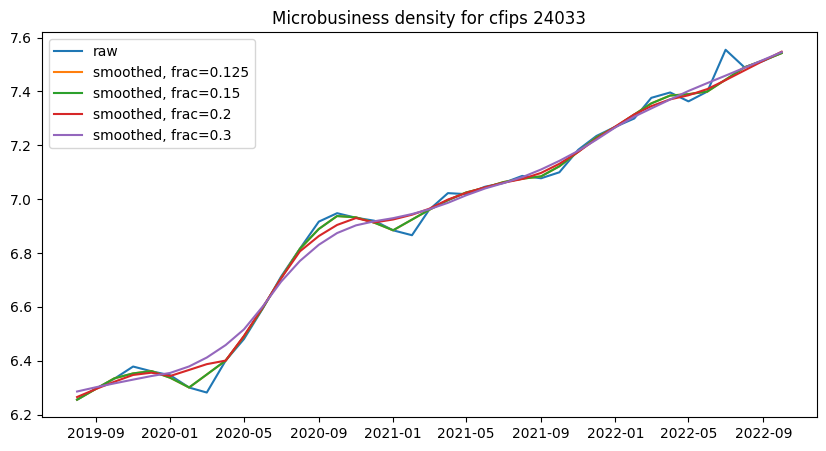

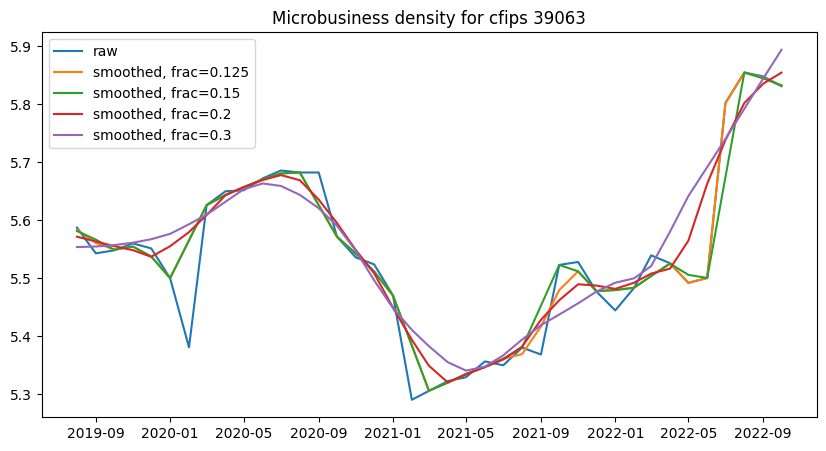

In [53]:
# plot smoothed microbusiness density, and microbusiness density for 2 random cfips
for i in range(2):
    fig, ax = plt.subplots(figsize=(10, 5))
    c = np.random.choice(cfips)
    temp_df = df[df["cfips"] == c]

    ax.plot(
        temp_df["first_day_of_month"], temp_df["microbusiness_density"], label="raw"
    )
    for frac in fraclist:
        ax.plot(
            temp_df["first_day_of_month"],
            temp_df[f"lowess_microbusiness_density_{frac}"],
            label=f"smoothed, frac={frac}",
        )

    plt.legend()
    plt.title(f"Microbusiness density for cfips {c}")
    plt.show()

In [54]:
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,STNAME,CTYNAME,POPESTIMATE2020,POPESTIMATE2021,year,population,quarter,pop_group_2020,pop_group_2022,lowess_microbusiness_density_0.125,lowess_microbusiness_density_0.15,lowess_microbusiness_density_0.2,lowess_microbusiness_density_0.3
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.01,1249,Alabama,Autauga County,58877,59095,2019,41526,3,medium,medium,3.01,3.01,3.02,3.03
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.88,1198,Alabama,Autauga County,58877,59095,2019,41526,3,medium,medium,3.03,3.02,3.01,3.02
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.06,1269,Alabama,Autauga County,58877,59095,2019,41527,4,medium,medium,3.06,3.06,3.01,3.01
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.99,1243,Alabama,Autauga County,58877,59095,2019,41527,4,medium,medium,3.01,3.01,3.01,3.00
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.99,1243,Alabama,Autauga County,58877,59095,2019,41527,4,medium,medium,2.99,2.99,2.99,2.99


### Create the timeseries for lowess

In [55]:
# Create an empty list to store the new time series
time_series = []

# Loop over each cfips
for cfips in df["cfips"].unique():
    # Filter the data for the current cfips
    df_cfips = df[df["cfips"] == cfips].reset_index(drop=True)
    # Loop over the time series from 0 to 14 (inclusive)
    for i in range(0, 15):
        # Create a new time series with the values for the current cfips and range of first_day_of_month
        time_series.append(
            {
                "cfips": cfips,
                "population": df_cfips.loc[i + 23, "population"],
                "active": df_cfips.loc[i + 23, "active"],
                "microbusiness_density": df_cfips.loc[
                    i : i + 23, "microbusiness_density"
                ].values.tolist(),
                "lowess_microbusiness_density_0.125": df_cfips.loc[
                    i : i + 23, "lowess_microbusiness_density_0.125"
                ].values.tolist(),
                #as target we are using the original microbusiness density
                "target": df_cfips.loc[i + 24, "microbusiness_density"],
                "target_date": df_cfips.loc[i + 24, "first_day_of_month"],
            }
        )

In [56]:
# Create a new dataframe with the list of time series
new_df = pd.DataFrame(time_series)

In [57]:
new_df.head()

,cfips,population,active,microbusiness_density,lowess_microbusiness_density_0.125,target,target_date
0,1001,42174,1354,"[3.0076818, 2.8848701, 3.0558431, 2.9932332, 2...","[3.0076818000000265, 3.0321572147540987, 3.055...",3.22,2021-08-01
1,1001,42174,1358,"[2.8848701, 3.0558431, 2.9932332, 2.9932332, 2...","[3.0321572147540987, 3.055843099999644, 3.0122...",3.19,2021-09-01
2,1001,42174,1344,"[3.0558431, 2.9932332, 2.9932332, 2.96909, 2.9...","[3.055843099999644, 3.0122545210848077, 2.9867...",3.20,2021-10-01
3,1001,42175,1351,"[2.9932332, 2.9932332, 2.96909, 2.9093256, 2.9...","[3.0122545210848077, 2.9867384385390388, 2.960...",3.20,2021-11-01
4,1001,42174,1350,"[2.9932332, 2.96909, 2.9093256, 2.9332314, 3.0...","[2.9867384385390388, 2.9600524299638176, 2.936...",3.29,2021-12-01


In [59]:
# convert the list of microbusiness_density to a numpy array and then each into a column
new_df["lowess_microbusiness_density_0.125"] = new_df[
    "lowess_microbusiness_density_0.125"
].apply(lambda x: np.array(x))

new_df = pd.concat(
    [
        new_df.drop(["lowess_microbusiness_density_0.125"], axis=1),
        new_df["lowess_microbusiness_density_0.125"].apply(pd.Series),
    ],
    axis=1,
)
new_df.head()

,cfips,population,active,microbusiness_density,target,target_date,0,1,2,3,...,14,15,16,17,18,19,20,21,22,23
0,1001,42174,1354,"[3.0076818, 2.8848701, 3.0558431, 2.9932332, 2...",3.22,2021-08-01,3.01,3.03,3.06,3.01,...,3.12,3.04,3.00,3.05,3.11,3.15,3.20,3.23,3.22,3.22
1,1001,42174,1358,"[2.8848701, 3.0558431, 2.9932332, 2.9932332, 2...",3.19,2021-09-01,3.03,3.06,3.01,2.99,...,3.04,3.00,3.05,3.11,3.15,3.20,3.23,3.22,3.22,3.21
2,1001,42174,1344,"[3.0558431, 2.9932332, 2.9932332, 2.96909, 2.9...",3.20,2021-10-01,3.06,3.01,2.99,2.96,...,3.00,3.05,3.11,3.15,3.20,3.23,3.22,3.22,3.21,3.20
3,1001,42175,1351,"[2.9932332, 2.9932332, 2.96909, 2.9093256, 2.9...",3.20,2021-11-01,3.01,2.99,2.96,2.94,...,3.05,3.11,3.15,3.20,3.23,3.22,3.22,3.21,3.20,3.20
4,1001,42174,1350,"[2.9932332, 2.96909, 2.9093256, 2.9332314, 3.0...",3.29,2021-12-01,2.99,2.96,2.94,2.94,...,3.11,3.15,3.20,3.23,3.22,3.22,3.21,3.20,3.20,3.23


In [60]:
ids = new_df["cfips"].unique()
# create X, which is df_new without the target column
X = new_df.drop(
    ["target", "target_date", "cfips", "population", "active", "microbusiness_density"],
    axis=1,
)
y = new_df["target"]
grps = new_df["cfips"]
threshold = 0.1

In [67]:
# use the last target date as the validate date
val_date = new_df["target_date"].max()
y_val = y[new_df["target_date"] == val_date]
X_val = X[new_df["target_date"] == val_date]
y_train = y[new_df["target_date"] != val_date]
X_train = X[new_df["target_date"] != val_date]
y_test = df[df["first_day_of_month"] == df["first_day_of_month"].max()][
    "microbusiness_density"
]

In [69]:
# Shapes of the train and test sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (43890, 24)
y_train shape: (43890,)
X_test shape: (3135, 24)
y_val shape: (3135,)
y_test shape: (3135,)


In [71]:
# use lazypredict regressor
removed_regressors = [
    "TheilSenRegressor",
    "ARDRegression",
    "CCA",
    "IsotonicRegression",
    "StackingRegressor",
    "MultiOutputRegressor",
    "MultiTaskElasticNet",
    "MultiTaskElasticNetCV",
    "MultiTaskLasso",
    "MultiTaskLassoCV",
    "PLSCanonical",
    "PLSRegression",
    "RadiusNeighborsRegressor",
    "RegressorChain",
    "VotingRegressor",
    "QuantileRegressor",
    "GaussianProcessRegressor",
    "GammaRegressor",
    "KernelRidge",
]
REGRESSORS = [
    est
    for est in all_estimators()
    if (issubclass(est[1], RegressorMixin) and (est[0] not in removed_regressors))
]
REGRESSORS.append(("XGBRegressor", xgboost.XGBRegressor))
REGRESSORS.append(("LGBMRegressor", lightgbm.LGBMRegressor))
reg = LazyRegressor(
    verbose=1, ignore_warnings=False, custom_metric=None, regressors=REGRESSORS
)
models, predictions = reg.fit(X_train, X_val, y_train, y_val)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


  3%|▎         | 1/38 [00:04<02:31,  4.11s/it]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.825110815373566, 'Adjusted R-Squared': 0.8237611882253234, 'RMSE': 2.575769260794629, 'Time taken': 4.105023145675659}


  5%|▌         | 2/38 [00:18<06:14, 10.41s/it]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9073312936621705, 'Adjusted R-Squared': 0.9066161653817499, 'RMSE': 1.874960097844528, 'Time taken': 14.83081603050232}
{'Model': 'BayesianRidge', 'R-Squared': 0.8817624509414408, 'Adjusted R-Squared': 0.8808500068329503, 'RMSE': 2.1178889715984575, 'Time taken': 0.06229138374328613}


 16%|█▌        | 6/38 [00:20<01:14,  2.32s/it]

{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9151326904139817, 'Adjusted R-Squared': 0.9144777658383982, 'RMSE': 1.7943026430654838, 'Time taken': 1.3464934825897217}
{'Model': 'DummyRegressor', 'R-Squared': -0.00019525397629216457, 'Adjusted R-Squared': -0.007913802560032046, 'RMSE': 6.159817910875266, 'Time taken': 0.03191542625427246}
{'Model': 'ElasticNet', 'R-Squared': 0.8033123640240646, 'Adjusted R-Squared': 0.8017945173155686, 'RMSE': 2.7315805379890405, 'Time taken': 0.1165018081665039}


 18%|█▊        | 7/38 [00:21<01:00,  1.94s/it]

{'Model': 'ElasticNetCV', 'R-Squared': 0.9056685408143573, 'Adjusted R-Squared': 0.9049405810007061, 'RMSE': 1.8917064985504926, 'Time taken': 0.8040523529052734}


 21%|██        | 8/38 [00:21<00:44,  1.48s/it]

{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.8979382338908468, 'Adjusted R-Squared': 0.897150618975535, 'RMSE': 1.9676915434375382, 'Time taken': 0.22140955924987793}


 24%|██▎       | 9/38 [00:40<03:01,  6.24s/it]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9101281551597015, 'Adjusted R-Squared': 0.909434610376368, 'RMSE': 1.846448962695715, 'Time taken': 18.818923234939575}


 26%|██▋       | 10/38 [01:22<07:40, 16.45s/it]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9127550837370861, 'Adjusted R-Squared': 0.9120818110713916, 'RMSE': 1.8192632414954641, 'Time taken': 42.47575235366821}


 29%|██▉       | 11/38 [01:23<05:18, 11.81s/it]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.7056808249407112, 'Adjusted R-Squared': 0.7034095515640478, 'RMSE': 3.34144839503615, 'Time taken': 0.2932147979736328}


 34%|███▍      | 13/38 [01:23<02:32,  6.11s/it]

{'Model': 'HuberRegressor', 'R-Squared': 0.8995414099159758, 'Adjusted R-Squared': 0.8987661667770637, 'RMSE': 1.952176222912856, 'Time taken': 0.7497963905334473}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.854424770106138, 'Adjusted R-Squared': 0.8533013599719088, 'RMSE': 2.3500073567979314, 'Time taken': 0.11167144775390625}
{'Model': 'Lars', 'R-Squared': 0.7041344879517526, 'Adjusted R-Squared': 0.7018512814279076, 'RMSE': 3.350214789933673, 'Time taken': 0.044879913330078125}


 42%|████▏     | 16/38 [01:24<00:56,  2.57s/it]

{'Model': 'LarsCV', 'R-Squared': 0.8722261024097888, 'Adjusted R-Squared': 0.8712400659010541, 'RMSE': 2.2016412361708095, 'Time taken': 0.18278908729553223}
{'Model': 'Lasso', 'R-Squared': 0.8486023643464632, 'Adjusted R-Squared': 0.8474340224636063, 'RMSE': 2.396541897852801, 'Time taken': 0.10571765899658203}


 45%|████▍     | 17/38 [01:24<00:42,  2.03s/it]

{'Model': 'LassoCV', 'R-Squared': 0.9069847873373347, 'Adjusted R-Squared': 0.9062669850531212, 'RMSE': 1.8784622474159391, 'Time taken': 0.4839158058166504}
{'Model': 'LassoLars', 'R-Squared': 0.8486023643464633, 'Adjusted R-Squared': 0.8474340224636064, 'RMSE': 2.3965418978527997, 'Time taken': 0.042913198471069336}


 55%|█████▌    | 21/38 [01:25<00:13,  1.28it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9075055788191996, 'Adjusted R-Squared': 0.9067917955046211, 'RMSE': 1.8731961177582999, 'Time taken': 0.19943928718566895}
{'Model': 'LassoLarsIC', 'R-Squared': 0.8808998855250524, 'Adjusted R-Squared': 0.8799807849631878, 'RMSE': 2.1256001350532, 'Time taken': 0.0849771499633789}
{'Model': 'LinearRegression', 'R-Squared': 0.8808998855252685, 'Adjusted R-Squared': 0.8799807849634057, 'RMSE': 2.125600135051272, 'Time taken': 0.05945301055908203}


 58%|█████▊    | 22/38 [01:30<00:27,  1.74s/it]

{'Model': 'LinearSVR', 'R-Squared': 0.9245516037333326, 'Adjusted R-Squared': 0.9239693653055512, 'RMSE': 1.691805708233571, 'Time taken': 5.301213502883911}


 61%|██████    | 23/38 [01:37<00:45,  3.04s/it]

{'Model': 'MLPRegressor', 'R-Squared': 0.9010995086934735, 'Adjusted R-Squared': 0.900336289467957, 'RMSE': 1.9369780712979183, 'Time taken': 7.3163535594940186}


 68%|██████▊   | 26/38 [03:40<03:50, 19.22s/it]

{'Model': 'NuSVR', 'R-Squared': 0.48567355605302354, 'Adjusted R-Squared': 0.4817044773859086, 'RMSE': 4.41717806182616, 'Time taken': 122.52966499328613}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9121100785681541, 'Adjusted R-Squared': 0.9114318283706093, 'RMSE': 1.8259758008814828, 'Time taken': 0.03978753089904785}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9121100785681541, 'Adjusted R-Squared': 0.9114318283706093, 'RMSE': 1.8259758008814828, 'Time taken': 0.10456705093383789}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9186595330639561, 'Adjusted R-Squared': 0.9180318252805268, 'RMSE': 1.7566239922280038, 'Time taken': 0.07184028625488281}


 74%|███████▎  | 28/38 [03:40<02:00, 12.08s/it]

{'Model': 'PoissonRegressor', 'R-Squared': -6.5265544277861585, 'Adjusted R-Squared': -6.5846371629202, 'RMSE': 16.89754387652007, 'Time taken': 0.06482815742492676}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9197529426728818, 'Adjusted R-Squared': 0.9191336727771098, 'RMSE': 1.7447774409102157, 'Time taken': 0.08488726615905762}


 79%|███████▉  | 30/38 [06:11<04:32, 34.02s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9038657961536765, 'Adjusted R-Squared': 0.9031239244841228, 'RMSE': 1.9096969149992227, 'Time taken': 150.30599784851074}


 87%|████████▋ | 33/38 [06:11<01:27, 17.46s/it]

{'Model': 'Ridge', 'R-Squared': 0.8878921060098882, 'Adjusted R-Squared': 0.8870269647057845, 'RMSE': 2.0622607523254564, 'Time taken': 0.4431955814361572}
{'Model': 'RidgeCV', 'R-Squared': 0.9076775424284426, 'Adjusted R-Squared': 0.9069650861642248, 'RMSE': 1.8714540049865145, 'Time taken': 0.082763671875}
{'Model': 'SGDRegressor', 'R-Squared': -2869.4302448733893, 'Adjusted R-Squared': -2891.5814750589075, 'RMSE': 329.9886315567994, 'Time taken': 0.08125782012939453}


 95%|█████████▍| 36/38 [06:22<00:20, 10.11s/it]

{'Model': 'SVR', 'R-Squared': 0.4885437292133419, 'Adjusted R-Squared': 0.48459679979248016, 'RMSE': 4.404835897700196, 'Time taken': 10.431490421295166}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.8808998855252685, 'Adjusted R-Squared': 0.8799807849634057, 'RMSE': 2.125600135051272, 'Time taken': 0.06131100654602051}
{'Model': 'TweedieRegressor', 'R-Squared': 0.7918204589687801, 'Adjusted R-Squared': 0.7902139287486034, 'RMSE': 2.810247064927359, 'Time taken': 0.04148077964782715}
{'Model': 'XGBRegressor', 'R-Squared': 0.9135756078885835, 'Adjusted R-Squared': 0.9129086672420645, 'RMSE': 1.810688095460038, 'Time taken': 2.4590704441070557}
{'Model': 'LGBMRegressor', 'R-Squared': 0.701936495960988, 'Adjusted R-Squared': 0.6996363274410727, 'RMSE': 3.362636175973189, 'Time taken': 0.20014739036560059}


100%|██████████| 38/38 [06:24<00:00, 10.13s/it]


In [72]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LinearSVR,0.92,0.92,1.69,5.30
RANSACRegressor,0.92,0.92,1.74,0.08
PassiveAggressiveRegressor,0.92,0.92,1.76,0.07
DecisionTreeRegressor,0.91,0.92,1.79,1.35
XGBRegressor,0.91,0.91,1.81,2.46
GradientBoostingRegressor,0.91,0.91,1.82,42.48
OrthogonalMatchingPursuit,0.91,0.91,1.83,0.04
OrthogonalMatchingPursuitCV,0.91,0.91,1.83,0.10
ExtraTreesRegressor,0.91,0.91,1.85,18.82


## Train and validate on highest scoring model

In [73]:
# mean squared error function
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))


def rsquared(y_true, y_pred):
    return 1 - mse(y_true, y_pred) / np.var(y_true)


def smape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

In [74]:
# train the model with LinearSVR
model = LinearSVR()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print("Model:", model.__class__.__name__)
print(f"Model score: {model.score(X_val, y_val)}")
print("MSE:", mse(y_val, y_pred))
print("RMSE:", rmse(y_val, y_pred))
print("R2:", rsquared(y_val, y_pred))
print("SMAPE:", smape(y_val, y_pred))
print("using the real latest date mbd as prediction target:")
print(f"Model score: {model.score(X_val, y_test)}")
print("MSE:", mse(y_test, y_pred))
print("RMSE:", rmse(y_test, y_pred))
print("R2:", rsquared(y_test, y_pred))
print("SMAPE:", smape(y_test, y_pred))

Model: LinearSVR
Model score: 0.9215957999838307
MSE: 2.9743377763329275
RMSE: 1.724626851331304
R2: 0.9215957999838307
SMAPE: 0.004457977595350382
using the real latest date mbd as prediction target:
Model score: 0.9215957999838307
MSE: 2.9743377763329275
RMSE: 1.724626851331304
R2: 0.9215957999838307
SMAPE: 0.004457977595350382


### Test and submit

In [77]:
# train on whole dataset
model = LinearSVR()
model.fit(X, y)

LinearSVR()

In [83]:
latest_df = new_df[new_df["target_date"] == new_df["target_date"].max()].drop(
    ["target_date", "population", "active", "cfips", "microbusiness_density"], axis=1
)
latest_df[24] = latest_df["target"]
prediction_data = latest_df.iloc[:, -24:]
prediction_data.shape[1]

24

In [92]:
# Define the number of future instances to predict
n_future = test["first_day_of_month"].unique().shape[0]
# Get the list of unique IDs
ids = test["cfips"].unique()


# get the latest data
latest_data = new_df[new_df["target_date"] == new_df["target_date"].max()].drop(
    ["target_date", "population", "active", "microbusiness_density"],
    axis=1,
)
latest_data[24] = latest_data["target"]

# initialize predictions array
predictions = np.zeros((len(ids), 8))

# loop over each prediction
for i in range(8):
    # use the latest 24 instances for each prediction
    prediction_data = latest_data.iloc[:, -24:]
    prediction = model.predict(prediction_data)
    predictions[:, i] = prediction

    # use the last prediction as input for the next prediction
    latest_data[25 + i] = predictions[:, i]

# print the predictions
print(predictions)

[[3.47411455 3.48096562 3.48606305 ... 3.49332328 3.49429719 3.49531282]
 [8.3472338  8.33965216 8.33417909 ... 8.31734863 8.31356845 8.31169716]
 [1.23939069 1.24391438 1.24787852 ... 1.2569272  1.259028   1.26083799]
 ...
 [4.01168878 4.00993105 4.007778   ... 4.00126872 4.00219241 4.00326201]
 [3.11752066 3.11539333 3.11426718 ... 3.11372044 3.11470762 3.11562706]
 [1.78637456 1.78716301 1.78797084 ... 1.79091785 1.79335682 1.79620114]]


Text(0.5, 1.0, 'Prediction for the next 8 months, cfips: 1003')

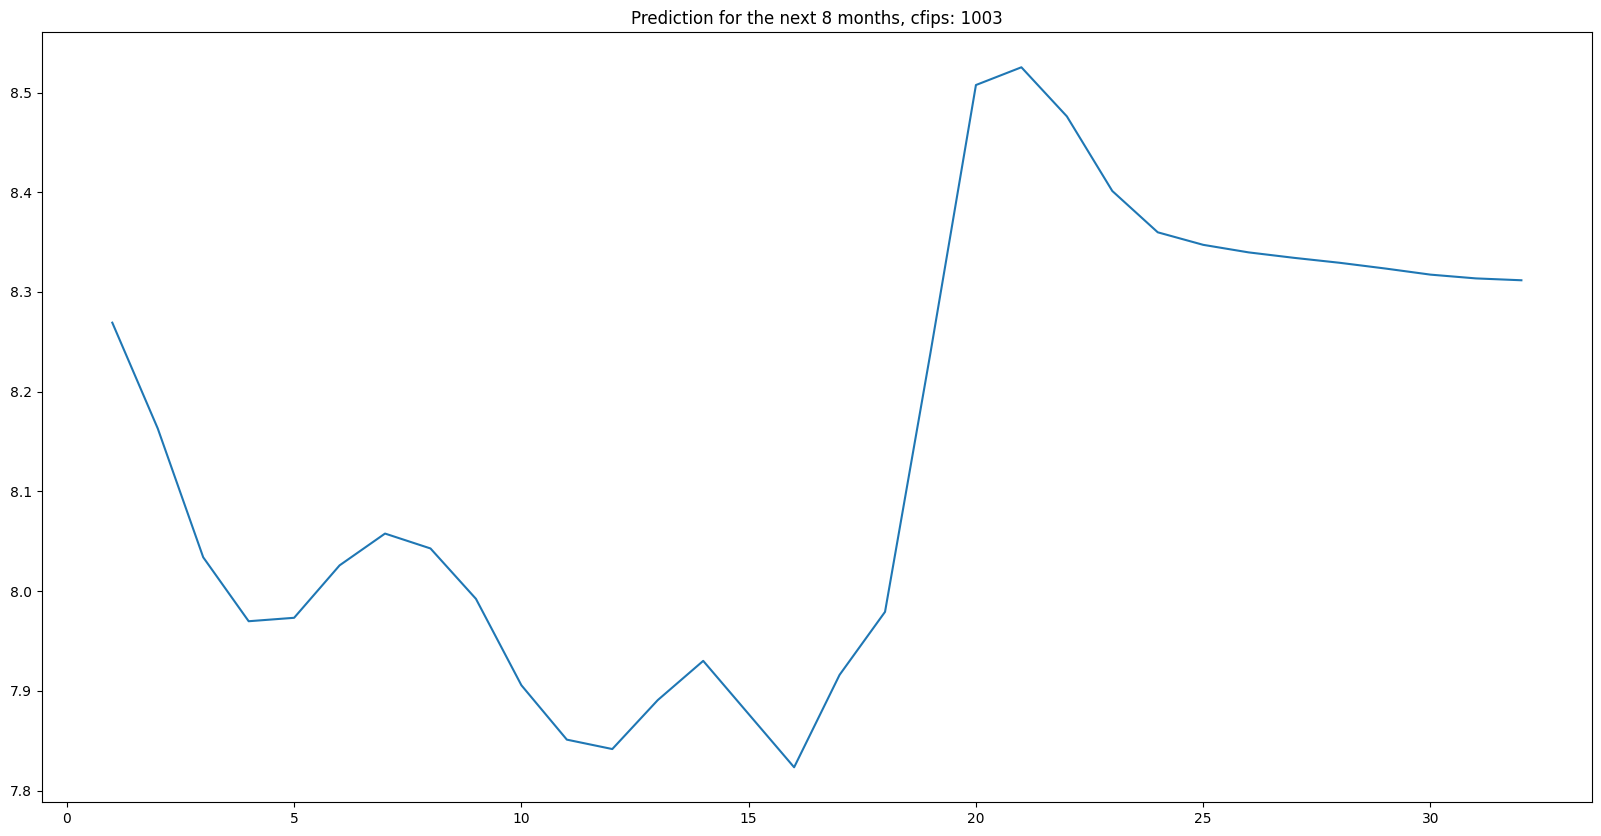

In [98]:
# Plot columns named 0-32 of the latest_data)
plt.figure(figsize=(20, 10))
plt.plot(latest_data.iloc[1, -32:].T)
plt.title(f"Prediction for the next 8 months, cfips: {ids[1]}")

In [105]:
test.sort_values(by=["cfips", "first_day_of_month"], inplace=True)

In [106]:
test["microbusiness_density"] = predictions.reshape(-1)

In [107]:
test[test["cfips"] == "38503"]

,row_id,cfips,first_day_of_month,microbusiness_density


In [108]:
result = test[["row_id", "microbusiness_density"]]
result.to_csv("../data/submissions/ml_test_smooth_1.csv", index=False)

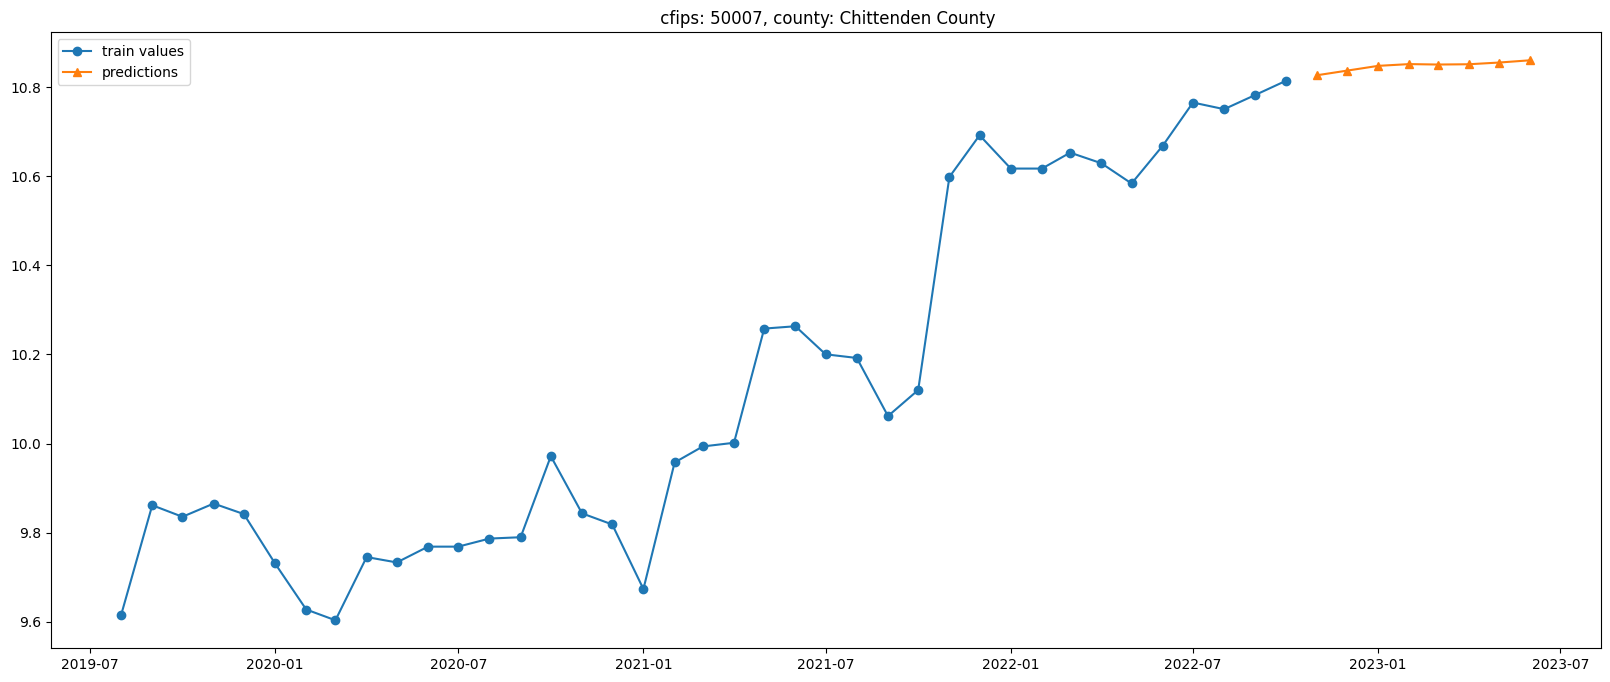

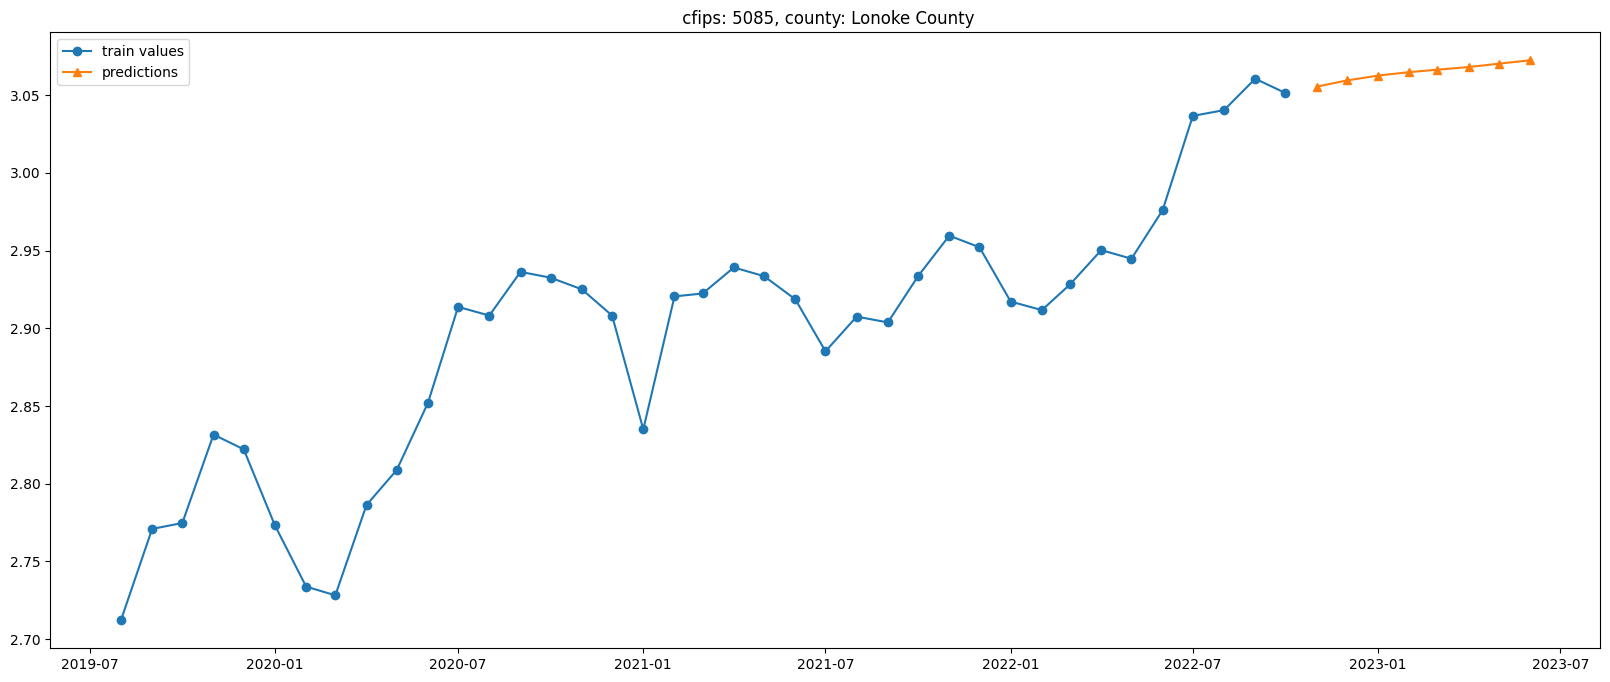

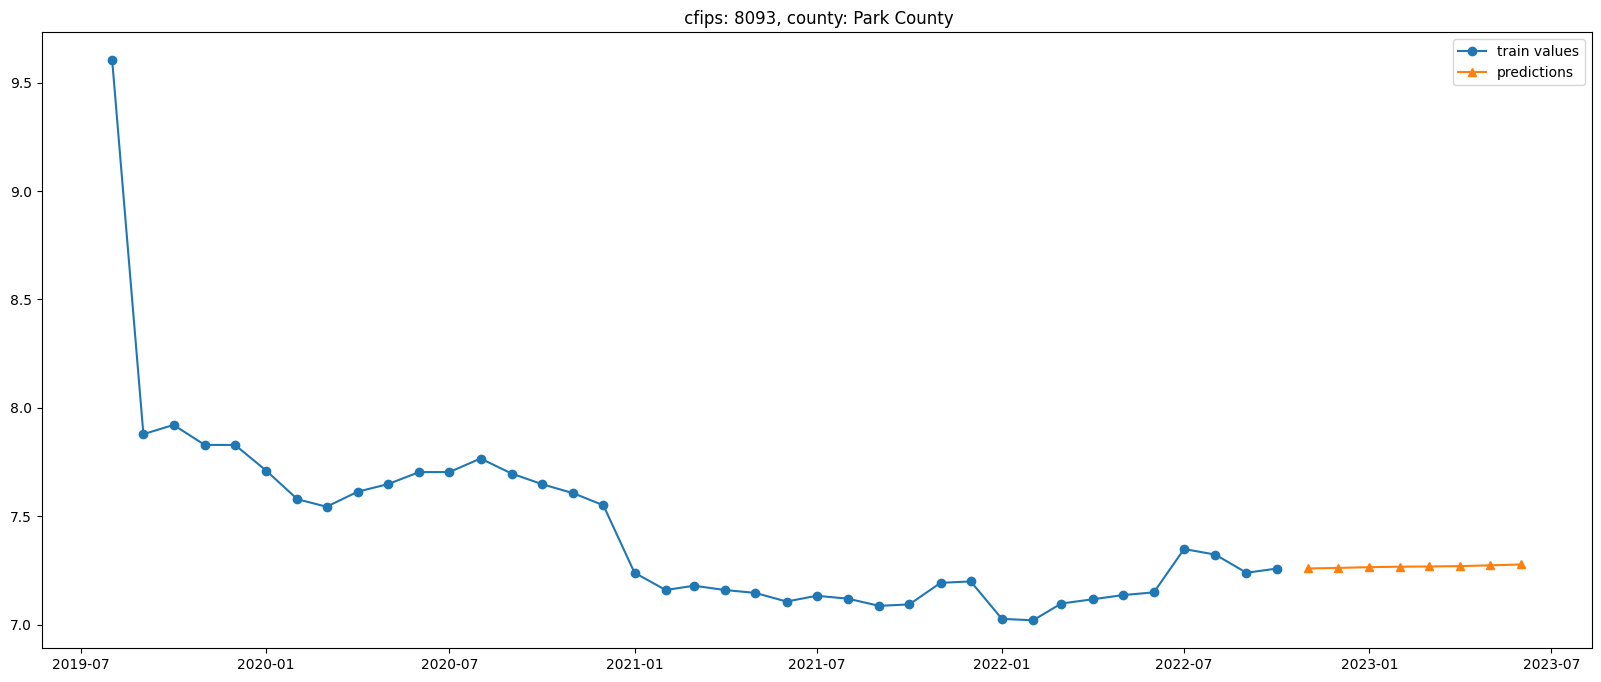

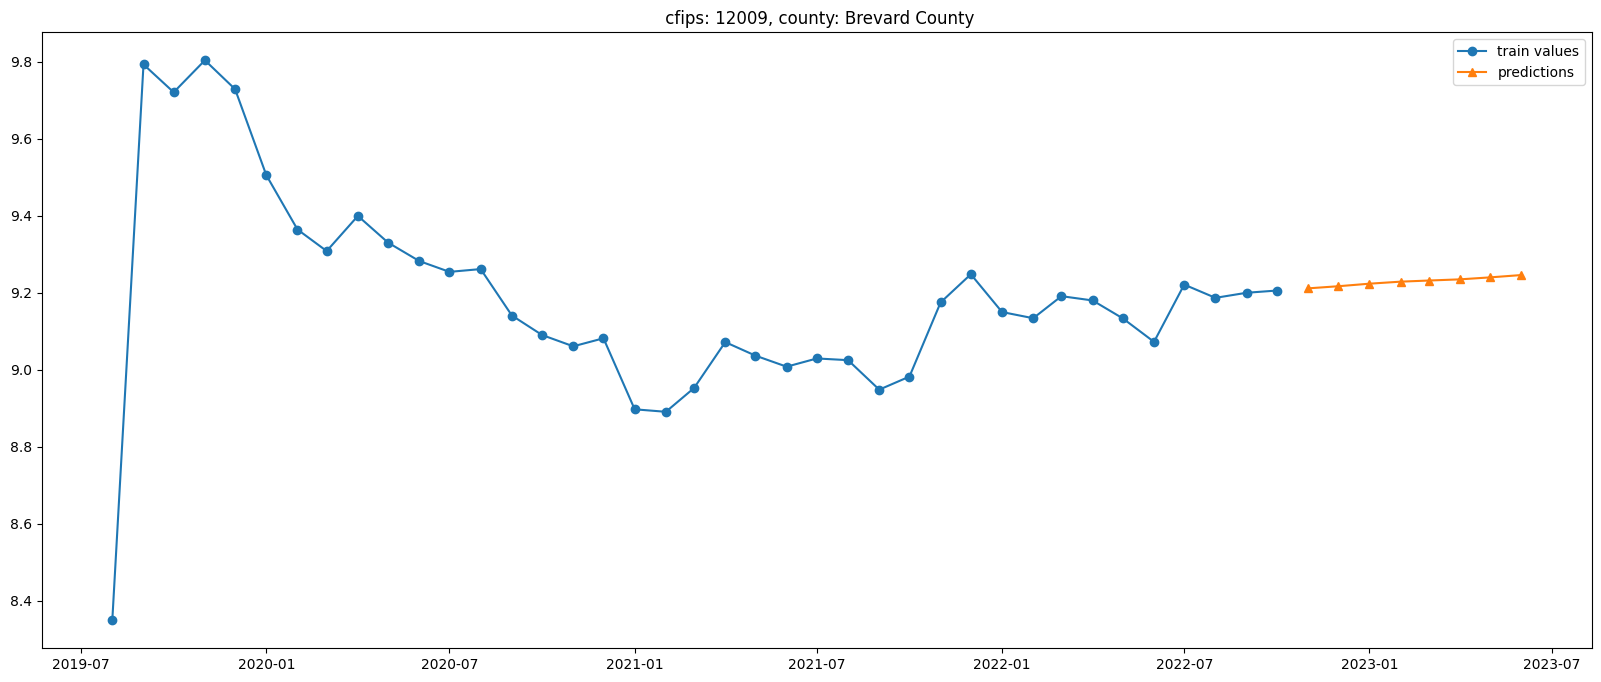

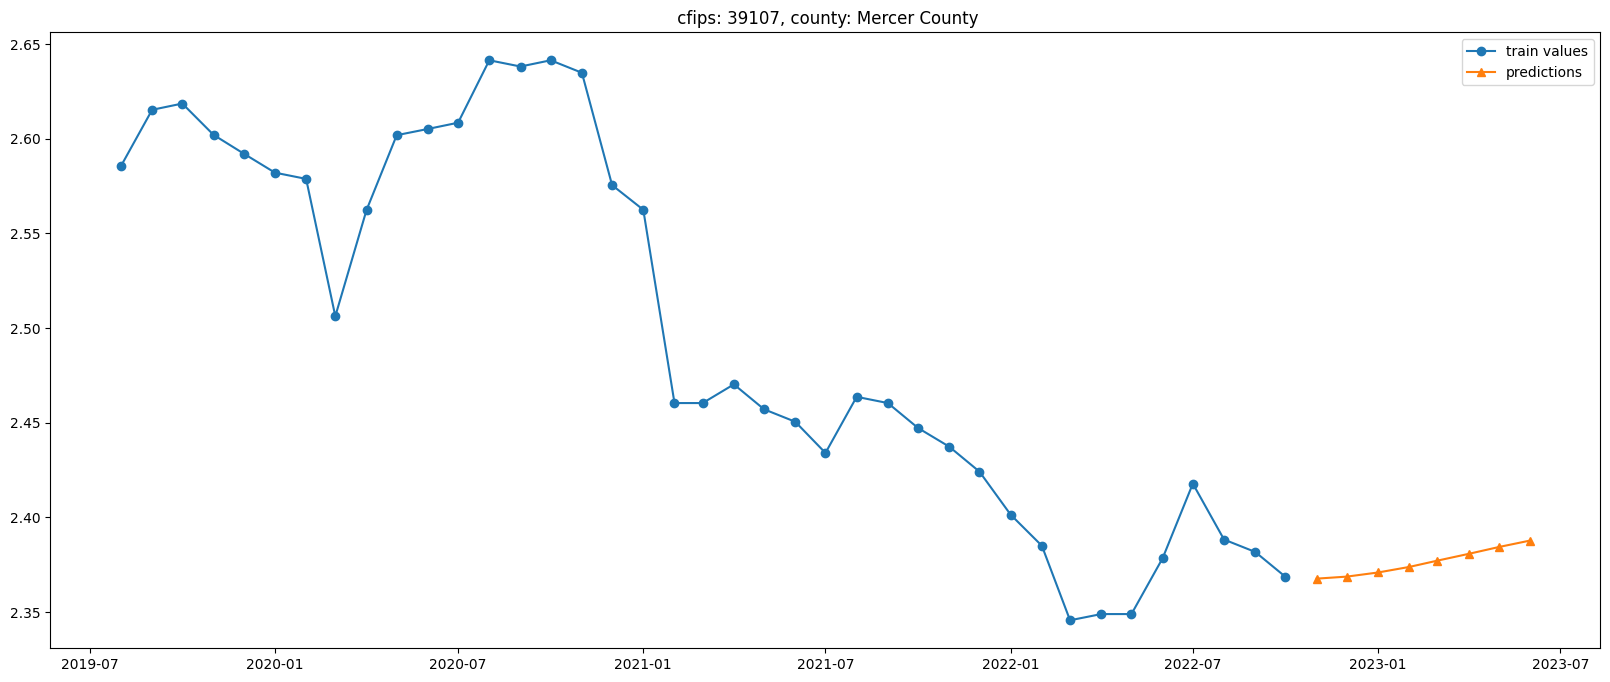

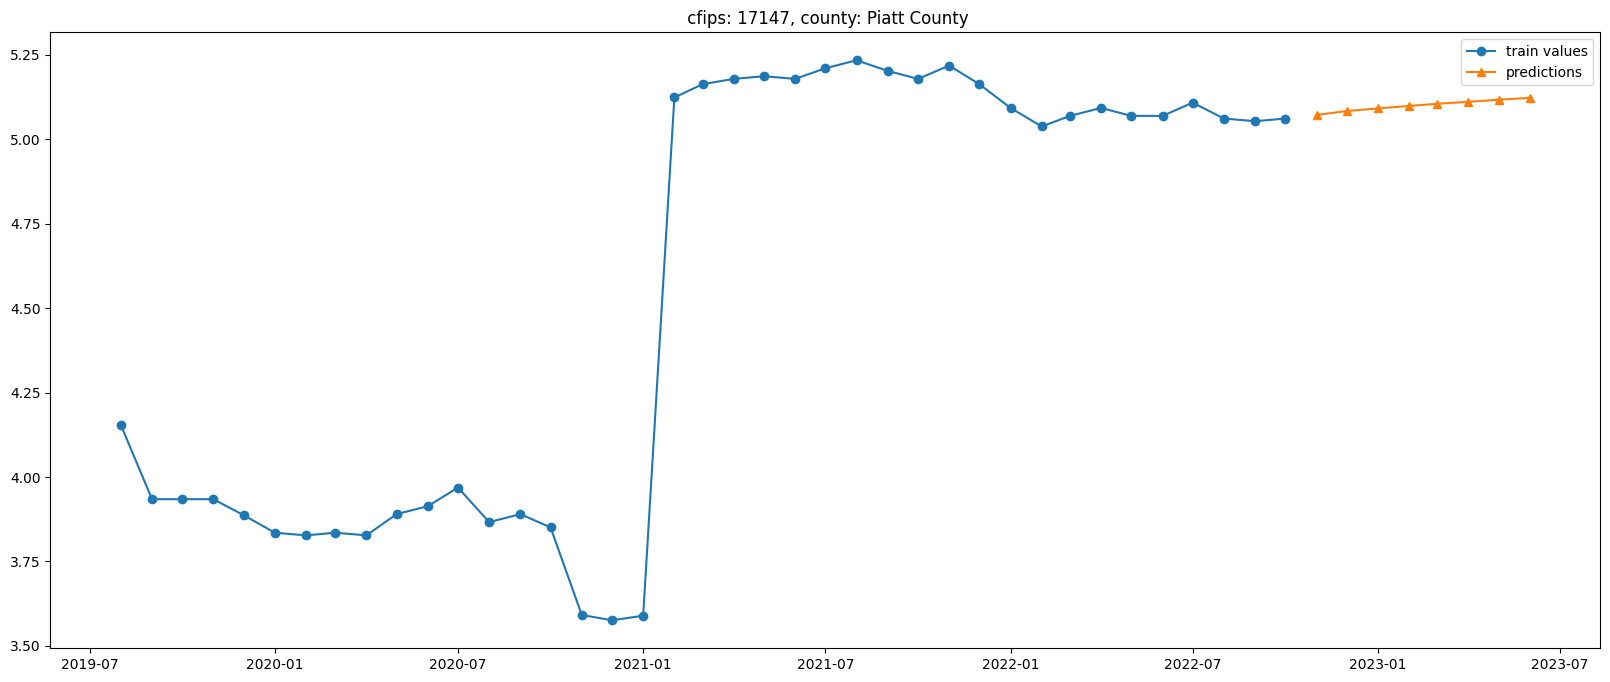

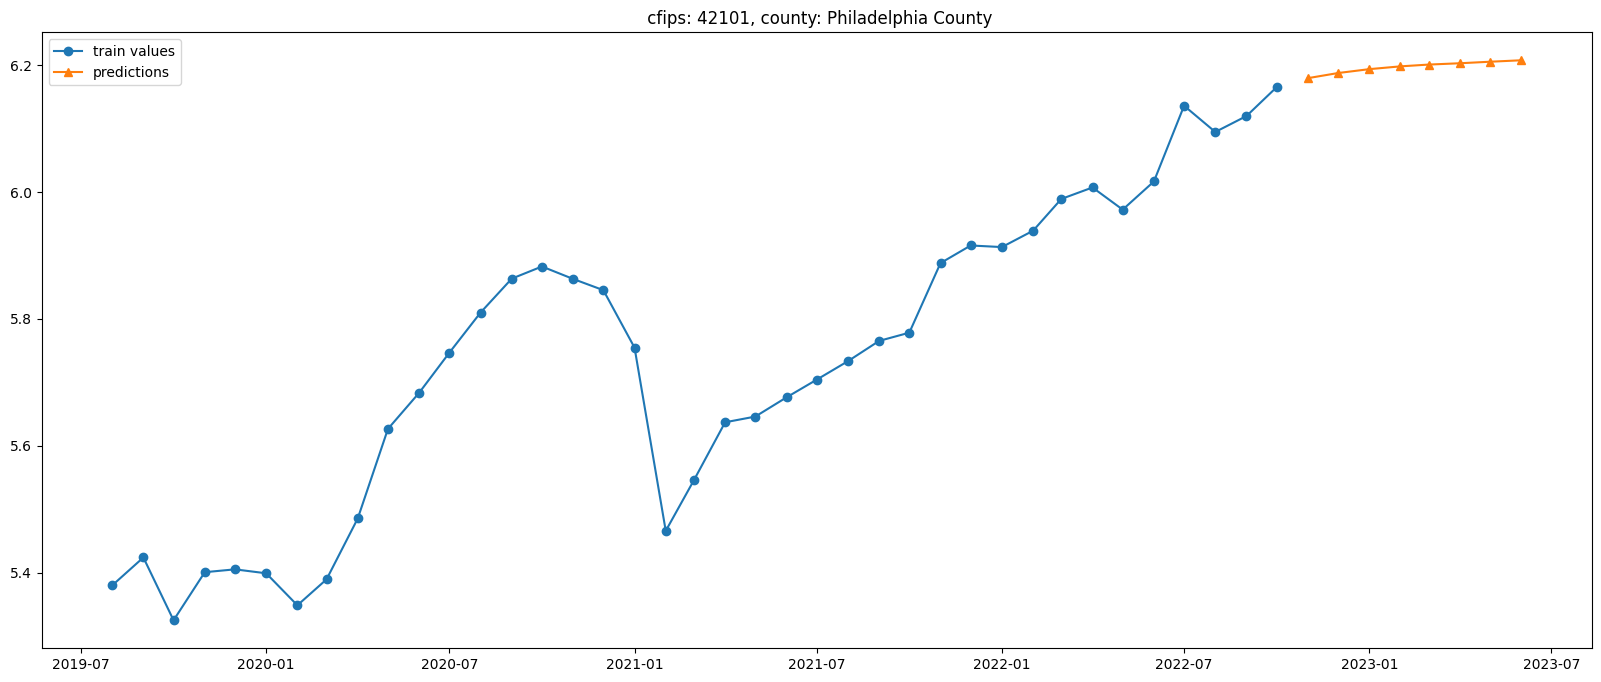

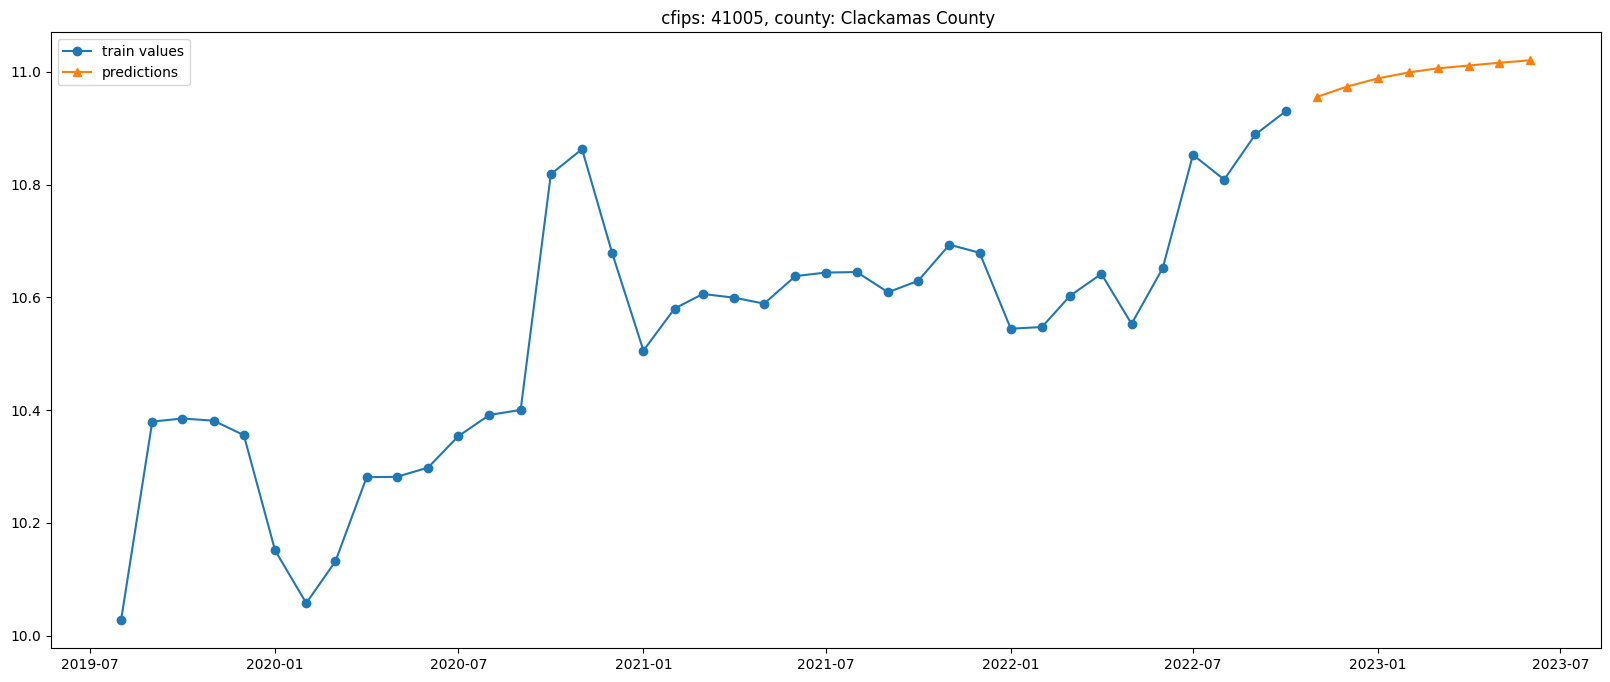

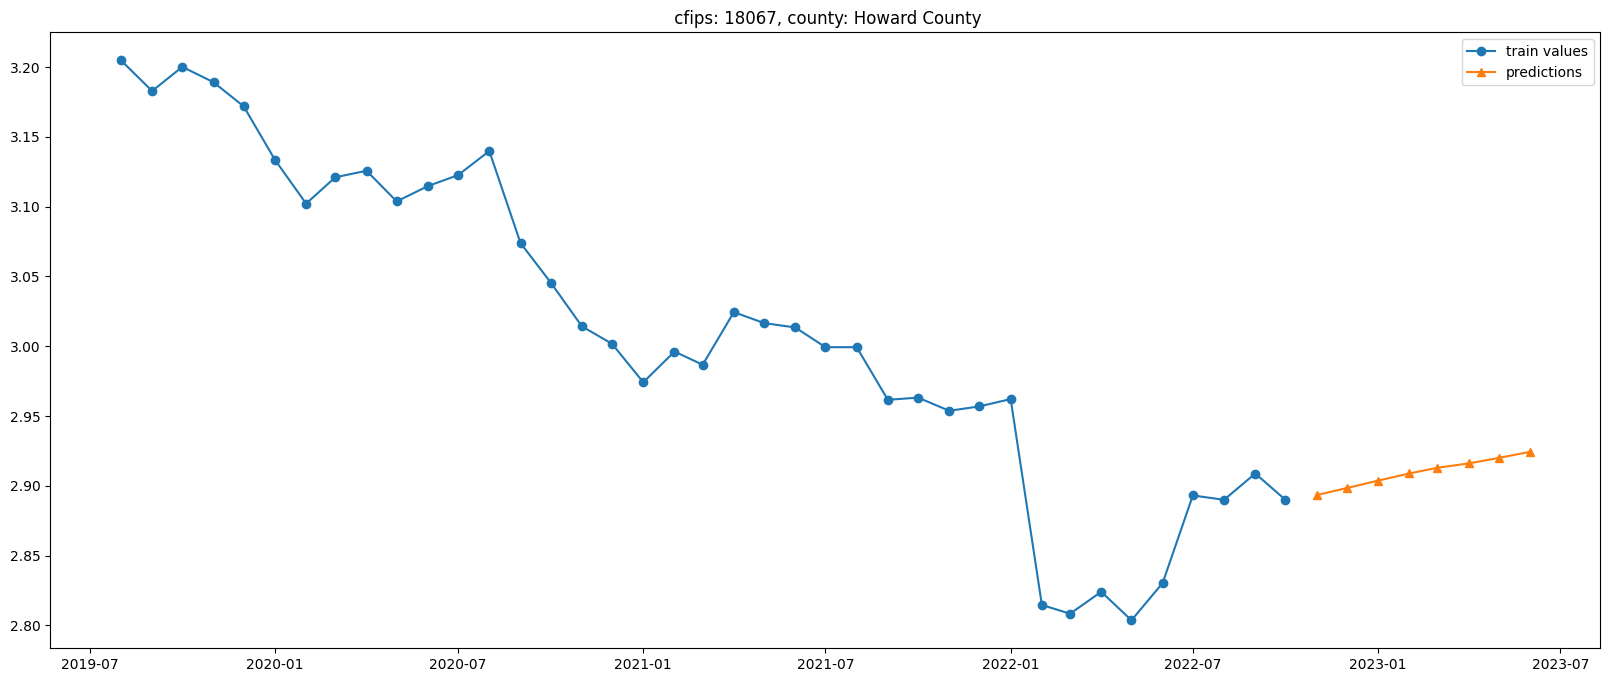

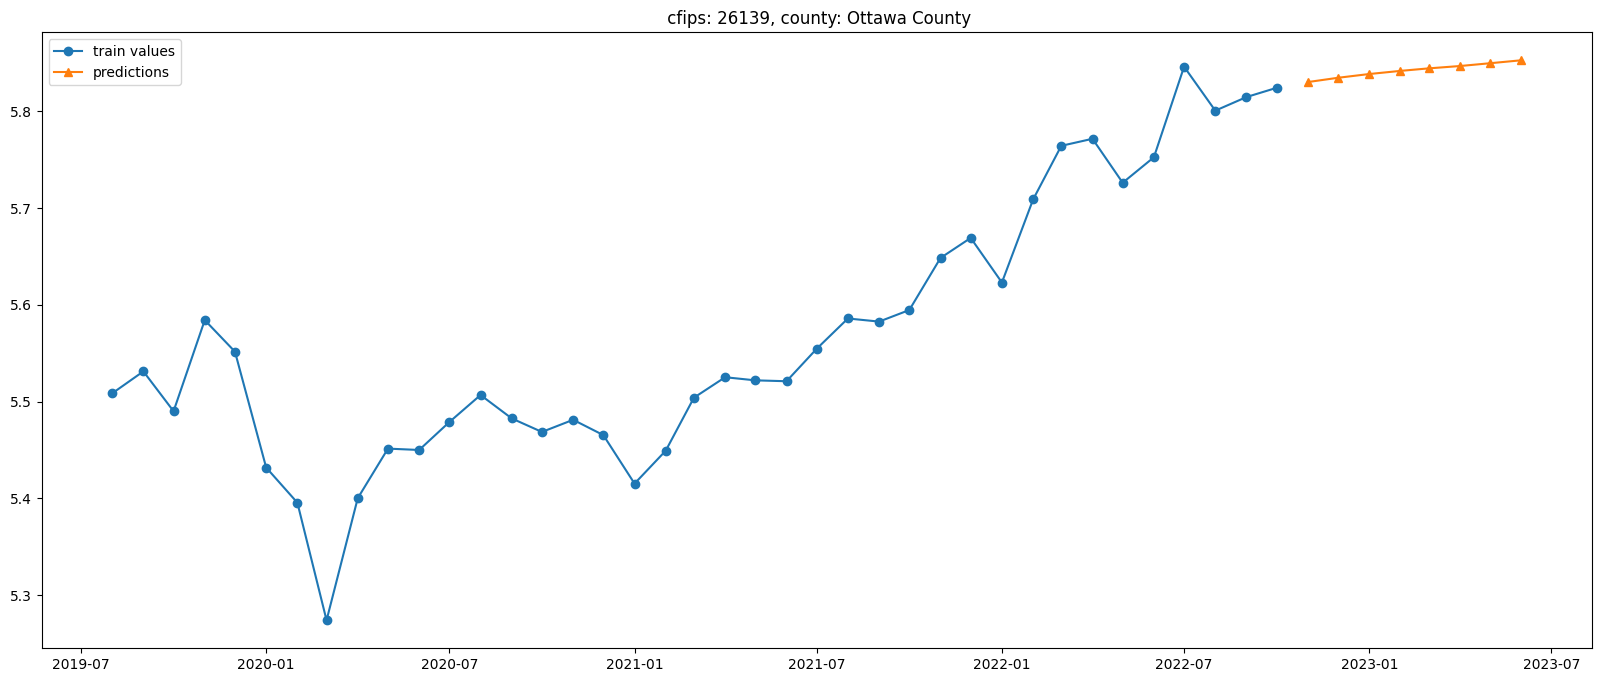

In [109]:
for i in range(10):
    c = np.random.choice(ids)
    plot_df = df[df["cfips"] == c].copy()
    test_plot = test[test["cfips"] == c].copy()
    plot_df["first_day_of_month"] = pd.to_datetime(plot_df["first_day_of_month"])
    test_plot["first_day_of_month"] = pd.to_datetime(test_plot["first_day_of_month"])
    last_target = plot_df["microbusiness_density"].values[-1]

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    plt.plot(
        plot_df["first_day_of_month"],
        plot_df["microbusiness_density"],
        "-o",
        label="train values",
    )
    plt.plot(
        test_plot["first_day_of_month"],
        test_plot["microbusiness_density"],
        "-^",
        label="predictions",
    )
    plt.title(f" cfips: {c}, county: {plot_df['county'].values[0]}")
    plt.legend()
    plt.show()

## Train with normalized values

In [110]:
df["microbusiness_density_norm"] = df["microbusiness_density"]
df.loc[
    df["first_day_of_month"] <= "2021-01-01",
    "microbusiness_density_norm",
] = (
    df.loc[df["first_day_of_month"] <= "2021-01-01", "microbusiness_density_norm"]
    - df.loc[
        df["first_day_of_month"] <= "2021-01-01", "microbusiness_density_norm"
    ].mean()
) / df.loc[df["first_day_of_month"] <= "2021-01-01", "microbusiness_density_norm"].std()
df.loc[
    df["first_day_of_month"] > "2021-01-01",
    "microbusiness_density_norm",
] = (
    df.loc[df["first_day_of_month"] > "2021-01-01", "microbusiness_density_norm"]
    - df.loc[
        df["first_day_of_month"] > "2021-01-01", "microbusiness_density_norm"
    ].mean()
) / df.loc[df["first_day_of_month"] > "2021-01-01", "microbusiness_density_norm"].std()

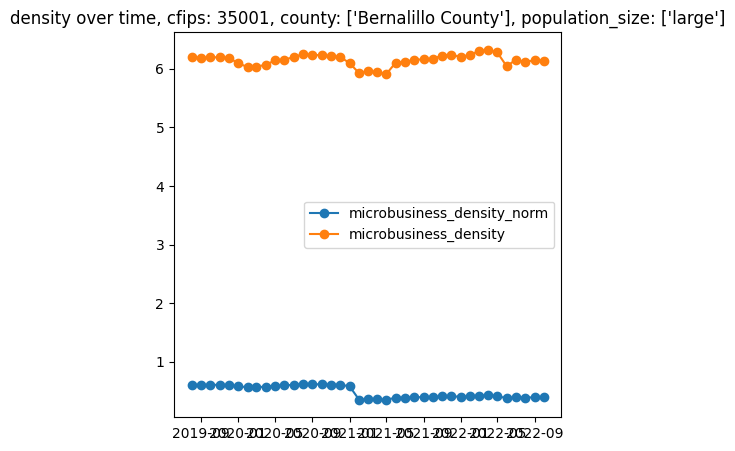

In [115]:
# plot some samples
for i in range(1):
    c = np.random.choice(ids)
    temp_df = df[df["cfips"] == c]
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(
        temp_df["first_day_of_month"],
        temp_df["microbusiness_density_norm"],
        "-o",
        label="microbusiness_density_norm",
    )
    ax.set_title(
        f"density over time, cfips: {c}, county: {temp_df['county'].unique()}, population_size: {temp_df['pop_group_2022'].unique()}"
    )
    # plot also a line for the density not normalized in the same graph
    ax.plot(
        temp_df["first_day_of_month"],
        temp_df["microbusiness_density"],
        "-o",
        label="microbusiness_density",
    )
    ax.legend()

In [132]:
# Create an empty list to store the new time series
time_series = []

# Loop over each cfips
for cfips in df["cfips"].unique():
    # Filter the data for the current cfips
    df_cfips = df[df["cfips"] == cfips].reset_index(drop=True)
    # Loop over the time series from 0 to 14 (inclusive)
    for i in range(0, 15):
        # Create a new time series with the values for the current cfips and range of first_day_of_month
        time_series.append(
            {
                "cfips": cfips,
                "population": df_cfips.loc[i + 23, "population"],
                "active": df_cfips.loc[i + 23, "active"],
                "microbusiness_density": df_cfips.loc[
                    i : i + 23, "microbusiness_density"
                ].values.tolist(),
                "microbusiness_density_norm": df_cfips.loc[
                    i : i + 23, "microbusiness_density_norm"
                ].values.tolist(),
                # as target we are using the original microbusiness density
                "target": df_cfips.loc[i + 24, "microbusiness_density_norm"],
                "target_date": df_cfips.loc[i + 24, "first_day_of_month"],
            }
        )

In [133]:
norm_df = pd.DataFrame(time_series)

In [134]:
# convert the list of microbusiness_density to a numpy array and then each into a column
norm_df["microbusiness_density_norm"] = norm_df["microbusiness_density_norm"].apply(
    lambda x: np.array(x)
)

norm_df = pd.concat(
    [
        norm_df.drop(["microbusiness_density_norm"], axis=1),
        norm_df["microbusiness_density_norm"].apply(pd.Series),
    ],
    axis=1,
)
norm_df.head()

,cfips,population,active,microbusiness_density,target,target_date,0,1,2,3,...,14,15,16,17,18,19,20,21,22,23
0,1001,42174,1354,"[3.0076818, 2.8848701, 3.0558431, 2.9932332, 2...",-0.12,2021-08-01,-0.18,-0.21,-0.16,-0.18,...,-0.13,-0.17,-0.18,-0.19,-0.14,-0.13,-0.12,-0.12,-0.12,-0.12
1,1001,42174,1358,"[2.8848701, 3.0558431, 2.9932332, 2.9932332, 2...",-0.13,2021-09-01,-0.21,-0.16,-0.18,-0.18,...,-0.17,-0.18,-0.19,-0.14,-0.13,-0.12,-0.12,-0.12,-0.12,-0.12
2,1001,42174,1344,"[3.0558431, 2.9932332, 2.9932332, 2.96909, 2.9...",-0.12,2021-10-01,-0.16,-0.18,-0.18,-0.19,...,-0.18,-0.19,-0.14,-0.13,-0.12,-0.12,-0.12,-0.12,-0.12,-0.13
3,1001,42175,1351,"[2.9932332, 2.9932332, 2.96909, 2.9093256, 2.9...",-0.12,2021-11-01,-0.18,-0.18,-0.19,-0.20,...,-0.19,-0.14,-0.13,-0.12,-0.12,-0.12,-0.12,-0.12,-0.13,-0.12
4,1001,42174,1350,"[2.9932332, 2.96909, 2.9093256, 2.9332314, 3.0...",-0.11,2021-12-01,-0.18,-0.19,-0.20,-0.19,...,-0.14,-0.13,-0.12,-0.12,-0.12,-0.12,-0.12,-0.13,-0.12,-0.12


In [135]:
# create X, which is df_norm without the target column
X_norm = norm_df.drop(
    [
        "target",
        "target_date",
        "cfips",
        "population",
        "active",
        "microbusiness_density",
    ],
    axis=1,
)
y_norm = norm_df["target"]
grps = norm_df["cfips"]
threshold = 0.1

In [136]:
# use the last target date as the validate date
val_date = norm_df["target_date"].max()
y_val_norm = y_norm[norm_df["target_date"] == val_date]
X_val_norm = X_norm[norm_df["target_date"] == val_date]
y_train_norm = y_norm[norm_df["target_date"] != val_date]
X_train_norm = X_norm[norm_df["target_date"] != val_date]

In [121]:
# use lazypredict regressor
removed_regressors = [
    "TheilSenRegressor",
    "ARDRegression",
    "CCA",
    "IsotonicRegression",
    "StackingRegressor",
    "MultiOutputRegressor",
    "MultiTaskElasticNet",
    "MultiTaskElasticNetCV",
    "MultiTaskLasso",
    "MultiTaskLassoCV",
    "PLSCanonical",
    "PLSRegression",
    "RadiusNeighborsRegressor",
    "RegressorChain",
    "VotingRegressor",
    "QuantileRegressor",
    "GaussianProcessRegressor",
    "GammaRegressor",
    "KernelRidge",
]
REGRESSORS = [
    est
    for est in all_estimators()
    if (issubclass(est[1], RegressorMixin) and (est[0] not in removed_regressors))
]
REGRESSORS.append(("XGBRegressor", xgboost.XGBRegressor))
REGRESSORS.append(("LGBMRegressor", lightgbm.LGBMRegressor))
reg = LazyRegressor(
    verbose=0, ignore_warnings=False, custom_metric=None, regressors=REGRESSORS
)
models, predictions = reg.fit(X_train_norm, X_val_norm, y_train_norm, y_val_norm)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


 74%|███████▎  | 28/38 [06:02<04:07, 24.72s/it]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


100%|██████████| 38/38 [08:47<00:00, 13.88s/it]


In [122]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
XGBRegressor,0.93,0.93,0.29,2.53
RANSACRegressor,0.92,0.92,0.31,0.08
LinearSVR,0.92,0.92,0.32,5.74
ExtraTreeRegressor,0.91,0.91,0.32,0.23
GradientBoostingRegressor,0.91,0.91,0.32,40.21
OrthogonalMatchingPursuit,0.91,0.91,0.33,0.04
OrthogonalMatchingPursuitCV,0.91,0.91,0.33,0.11
ElasticNetCV,0.91,0.91,0.33,0.77
MLPRegressor,0.91,0.91,0.33,4.73


In [137]:
# train it with xgboost
xgb = xgboost.XGBRegressor()
xgb.fit(X_train_norm, y_train_norm)
y_pred_norm = xgb.predict(X_val_norm)

In [138]:
print("Model:", xgb.__class__.__name__)
print("R2 score:", rsquared(y_val_norm, y_pred_norm))
print("Mean squared error:", mse(y_val_norm, y_pred_norm))
print("Mean absolute error:", rmse(y_val_norm, y_pred_norm))

Model: XGBRegressor
R2 score: 0.9304850614344187
Mean squared error: 0.08205850629837562
Mean absolute error: 0.2864585594782876


### Use normalized model and remember to return the predictions to the normal range

In [145]:
# Define the number of future instances to predict
n_future = test["first_day_of_month"].unique().shape[0]
# Get the list of unique IDs
ids = test["cfips"].unique()


# get the latest data
norm_latest_data = norm_df[norm_df["target_date"] == norm_df["target_date"].max()].drop(
    ["target_date", "population", "active", "microbusiness_density"],
    axis=1,
)
norm_latest_data[24] = norm_latest_data["target"]

# initialize norm_predictions array
norm_predictions = np.zeros((len(ids), 8))

# loop over each prediction
for i in range(8):
    # use the latest 24 instances for each prediction
    norm_prediction_data = norm_latest_data.iloc[:, -24:]
    norm_prediction = model.predict(norm_prediction_data)
    norm_predictions[:, i] = norm_prediction

    # use the last prediction as input for the next prediction
    norm_latest_data[25 + i] = norm_predictions[:, i]
# remove normalization
norm_predictions = (
    norm_predictions * df["microbusiness_density"].std()
    + df["microbusiness_density"].mean()
)

# print the norm_predictions
print(norm_predictions)

[[3.44993405 3.46261482 3.47356218 ... 3.50166598 3.51007515 3.518703  ]
 [7.74774594 7.7452038  7.74945386 ... 7.75642516 7.76345439 7.76856232]
 [1.48571808 1.49902147 1.51059992 ... 1.54204953 1.55162234 1.56068414]
 ...
 [3.92222144 3.92564792 3.92883071 ... 3.94525934 3.95299201 3.96096964]
 [3.13063249 3.1345409  3.13910258 ... 3.15792371 3.16656558 3.17479102]
 [1.96588401 1.97466946 1.98257674 ... 2.00746291 2.01751276 2.02790011]]


Text(0.5, 1.0, 'Prediction for the next 8 months, cfips: 1003')

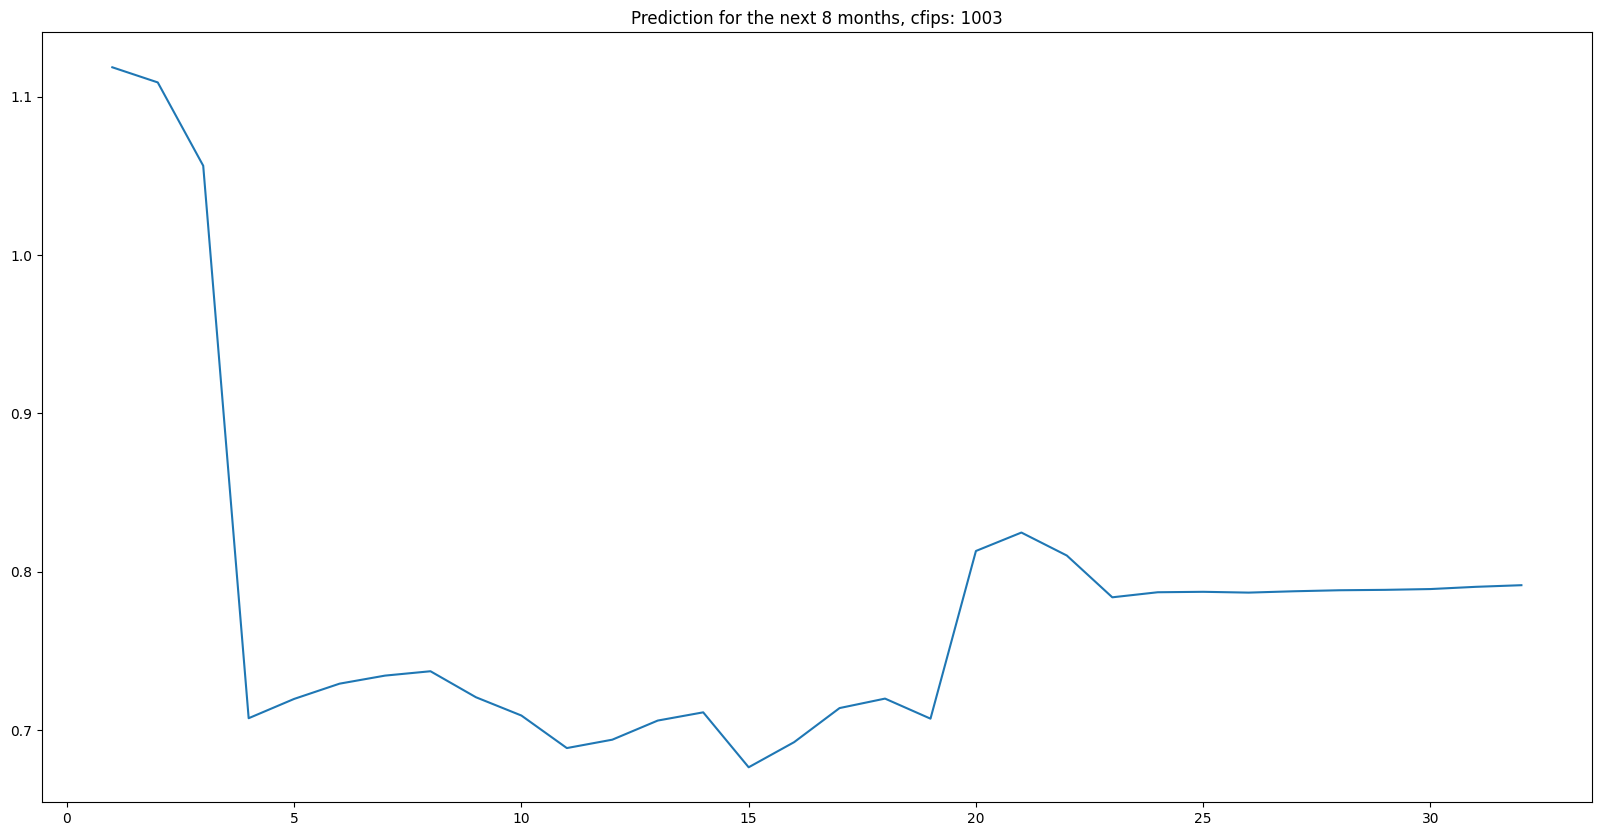

In [146]:
# Plot columns named 0-32 of the latest_data)
plt.figure(figsize=(20, 10))
plt.plot(norm_latest_data.iloc[1, -32:].T)
plt.title(f"Prediction for the next 8 months, cfips: {ids[1]}")

In [147]:
norm_test = test.copy()
norm_test["microbusiness_density"] = norm_predictions.reshape(-1)

In [148]:
norm_test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.45
3135,1001_2022-12-01,1001,2022-12-01,3.46
6270,1001_2023-01-01,1001,2023-01-01,3.47
9405,1001_2023-02-01,1001,2023-02-01,3.48
12540,1001_2023-03-01,1001,2023-03-01,3.49


In [149]:
norm_result = norm_test[["row_id", "microbusiness_density"]]
norm_result.to_csv("../data/submissions/ml_normalized.csv", index=False)